In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from matplotlib_venn import venn2
from adjustText import adjust_text
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import umap
from matplotlib.ticker import LogLocator
import seaborn as sns
import plotly.io as pio
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind, mannwhitneyu
#from brokenaxes import brokenaxes
import os
import re
import importlib
#import my_plsda
import sys
import glob

from ast import literal_eval
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines


In [2]:
# # import custom functions
# import sys
# sys.path.append(
#     '/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/COPASI_Modeling/Basico_python/Copasi_basico_cluster/my_plsda')


In [2]:
#sns.set_context("notebook", font_scale=1.5)

# plot settings
plt.rcParams['xtick.labelsize'] = 16  # or whatever size you want
plt.rcParams['ytick.labelsize'] = 16 # or whatever size you want

# Set global font size for labels, titles and legends
plt.rcParams['axes.labelsize'] = 18 # or whatever size you want
plt.rcParams['axes.titlesize'] = 18 # or whatever size you want
plt.rcParams['legend.fontsize'] = 18 # or whatever size you want
#plt.style.use(['ieee', 'no-latex', 'nature'])

In [3]:
# load all the files
# import file
folder_path = "/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/processed_simulations/"
model_name = "ap1_model_new_simulations_V7_highFOS_range.csv"
model_path = os.path.join(folder_path, model_name)
# read model file
model_states = pd.read_csv(model_path)
input_name = "parameter_initial_condition_input_V7.csv"
input_path = os.path.join(folder_path, input_name)

# read input file
input_states = pd.read_csv(input_path)
# load the experimental data from the new replicates analysis
#exp_name = "experimental_data/ap1_singlecell_replicate_avg_frq_states_v2.csv"
#exp_path = os.path.join(folder_path, exp_name)
exp_new = pd.read_csv("experimental_data/ap1_singlecell_replicate_avg_frq_states_v2.csv", index_col=0)

## Model Calibration

#### This script will identify parameters and inital conditions from simulations that matches the six recurrent AP-1 states in the experimental data.
- Make sure to import the necessary files in the working directory
- The script will generate the calibrated steady states, and the calibrated parameters and initial conditions in a separate csv file.

In [5]:
# remove the brackets and commas from the state names
exp_new['state'] = exp_new['state'].str.replace(
    r"[()'\s]", "", regex=True)
exp_new['state'] = exp_new['state'].str.replace(",", ", ", regex=True)
# rename all rows thta say A375 _x001A_NRAS(Q61K) to A375_NRAS(Q61K) in the cell_line column
exp_new['cell_line'] = exp_new['cell_line'].replace(
    {'A375 _x001A_NRAS(Q61K)': 'A375_NRAS(Q61K)'})
exp_new['cell_line'].unique()


array(['A101D', 'A2058', 'A375', 'A375_NRAS(Q61K)', 'C32', 'COLO858',
       'HS294T', 'IGR39', 'LOXIMVI', 'MMACSF', 'RVH421', 'SKMEL19',
       'SKMEL28', 'SKMEL5', 'UACC62', 'WM115', 'WM1552C', 'WM2664',
       'WM902B'], dtype=object)

#### Plot the AP-1 state intersection as a venn diagram between experiments and simulations

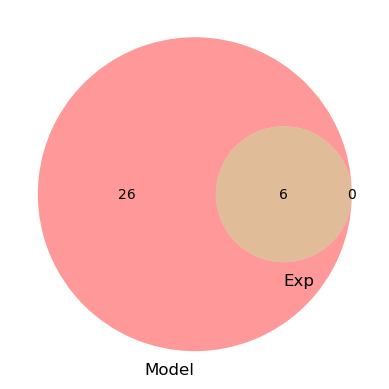

In [6]:
# plot the overlap as venn diagram
# Get unique states in each DataFrame
states_model = set(model_states['state'])
states_exp = set(exp_new['state'])

venn2([states_model, states_exp], set_labels = ('Model', 'Exp'))
# save figure
#plt.savefig('overlap_model_exp.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# plot the overlap per cell line
grouped = exp_new.groupby('cell_line')
model_states_set = set(model_states['state'].unique())
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
# for each cell line
for i, (cell_line, group) in enumerate(grouped):

    group_state_sets = set(group['state'].unique())

    intersection = model_states_set & group_state_sets

    # Create a Venn diagram
    venn = venn2([model_states_set, group_state_sets],
          set_labels=(None,None), ax=axs[i])
    axs[i].set_title(f'{cell_line}')
    axs[i].set_xlim(-0.75, 0.75)
    axs[i].set_ylim(-0.75, 0.75)

    # Adjust font size of labels
    for text in venn.set_labels:
        text.set_fontsize(34)  # Adjust as needed

    # Adjust font size of subset labels
    for label in venn.subset_labels:
        if label:  # Check if label is not None
            label.set_fontsize(34)  
  
# Remove unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
#plt.savefig('AP1_protein_distribution_gridthresholds.pdf', dpi=500)
plt.show()


In [7]:
model_states

,param_index,init_cond_index,fos,jun,fra1,fra2,jund,state
0,0,101,0.7,0.5,0.6,9.2,1.0,"low, low, low, low, low"
1,0,71,0.7,0.5,0.6,9.2,1.0,"low, low, low, low, low"
2,0,70,0.7,0.5,0.6,9.2,1.0,"low, low, low, low, low"
3,0,69,0.7,0.5,0.6,9.2,1.0,"low, low, low, low, low"
4,0,68,0.7,0.5,0.6,9.2,1.0,"low, low, low, low, low"
...,...,...,...,...,...,...,...,...
3935395,19999,71,3.0,0.2,0.3,3.8,0.9,"low, low, low, low, low"
3935396,19999,72,3.0,0.2,0.3,3.8,0.9,"low, low, low, low, low"
3935397,19999,73,3.0,0.2,0.3,3.8,0.9,"low, low, low, low, low"
3935398,19999,63,3.0,0.2,0.3,3.8,0.9,"low, low, low, low, low"


In [8]:
# subset the model states to only include the states that are in the experimental data
model_states_subset = model_states[model_states['state'].isin(exp_new['state'].unique())]
unique_model_states = model_states_subset['state'].unique()
# rename the state column in model_states_subset from state to model_steadystate
model_states_subset.rename(
    columns={'state': 'model_steadystate'}, inplace=True)

# final df is model_states_subset which only contains the six experimental states
model_states_subset


/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/2935854794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_states_subset.rename(


,param_index,init_cond_index,fos,jun,fra1,fra2,jund,model_steadystate
600,3,197,1.6,0.3,16.7,4.1,12.7,"low, low, high, low, high"
601,3,71,1.6,0.3,16.7,4.1,12.7,"low, low, high, low, high"
602,3,70,1.6,0.3,16.7,4.1,12.7,"low, low, high, low, high"
603,3,69,1.6,0.3,16.7,4.1,12.7,"low, low, high, low, high"
604,3,68,1.6,0.3,16.7,4.1,12.7,"low, low, high, low, high"
...,...,...,...,...,...,...,...,...
3932795,19986,70,1.2,12.5,13.2,58.3,28.4,"low, high, high, high, high"
3932796,19986,71,1.2,12.5,13.2,58.3,28.4,"low, high, high, high, high"
3932797,19986,72,1.2,12.5,13.2,58.3,28.4,"low, high, high, high, high"
3932798,19986,73,1.2,12.5,13.2,58.3,28.4,"low, high, high, high, high"


In [29]:
# #Calculate unique steady states for each param_index
# def count_uniq_steadystates(data):
#     # Group by 'param_index' and count unique 'model_steadystate' values
#     unique_counts = data.groupby('param_index').apply(lambda x: x['model_steadystate'].drop_duplicates().shape[0])

#     # Create a DataFrame from the unique_counts Series
#     params_steady_states = pd.DataFrame(unique_counts, columns=['num_unique_steady_states'])

#     # Filter the DataFrame to identify parameters with more than one unique steady state
#     params_more_than_one_ss = params_steady_states[params_steady_states['num_unique_steady_states'] > 1]

#     # Similarly, get the parameters with only one steady state
#     params_one_ss = params_steady_states[params_steady_states['num_unique_steady_states'] == 1]

#     # Count the distribution of unique steady states
#     count_distribution = unique_counts.value_counts().sort_index()

#     # Plot the result
#     plt.figure(figsize=(8,4))
#     bars = sns.barplot(x=count_distribution.index, y=count_distribution.values, color='#B25900', width=1.0,edgecolor='black')
#     bars.set_ylabel('# parameters', fontsize=20)
#     bars.set_xlabel('# Unique Steady States', fontsize=20)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     # make y axis log scale
#     plt.yscale('log')
#     # Create custom legend using patches
#     patches = [mpatches.Patch(color='#B25900', label=f'{index} State: {value} Params') for index, value in count_distribution.items()]
#     plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title=None)

#     plt.tight_layout()
#     plt.show()

#     print("Parameters with more than one unique steady state:")
#     print(params_more_than_one_ss)
    
#     print("Parameters with only one unique steady state:")
#     print(params_one_ss)
#     params_more_than_one_ss.to_csv('parameters_more_than_one_unique_steady_state_new_highfos_range.csv')
#     params_one_ss.to_csv('parameters_one_unique_steady_state_new_highfos_range.csv')


In [9]:
def count_uniq_steadystates(data, steady_state_cols, decimals=3):
    # Round the steady state values to mitigate minor numerical differences
    data[steady_state_cols] = data[steady_state_cols].round(decimals)
    
    # Create a tuple of the steady state values for each row
    data['steady_state_values'] = data[steady_state_cols].apply(tuple, axis=1)
    
    # Group by 'param_index' and count the number of unique steady state value tuples
    unique_counts = data.groupby('param_index')['steady_state_values'].nunique()
    
    # Create a DataFrame from the unique_counts Series
    params_steady_states = unique_counts.reset_index()
    params_steady_states.columns = ['param_index', 'num_unique_steady_states']
    
    # Filter the DataFrame to identify parameters with more than one unique steady state
    params_more_than_one_ss = params_steady_states[params_steady_states['num_unique_steady_states'] > 1]
    
    # Similarly, get the parameters with only one steady state
    params_one_ss = params_steady_states[params_steady_states['num_unique_steady_states'] == 1]
    
    # Count the distribution of unique steady states
    count_distribution = unique_counts.value_counts().sort_index()
    
    # Plot the result
    plt.figure(figsize=(8,4))
    bars = sns.barplot(x=count_distribution.index, y=count_distribution.values, color='#B25900', width=1.0, edgecolor='black')
    bars.set_ylabel('# Parameters', fontsize=20)
    bars.set_xlabel('# Unique Steady States', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.yscale('log')  # Make y-axis log scale
    
    # Create custom legend using patches
    patches = [mpatches.Patch(color='#B25900', label=f'{index} State: {value} Params') for index, value in count_distribution.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print("Parameters with more than one unique steady state:")
    print(params_more_than_one_ss)
    
    print("Parameters with only one unique steady state:")
    print(params_one_ss)
    
    # Save the results to CSV files
    #params_more_than_one_ss.to_csv('parameters_more_than_one_unique_steady_state.csv', index=False)
    #params_one_ss.to_csv('parameters_one_unique_steady_state.csv', index=False)
    
    return params_more_than_one_ss, params_one_ss

In [10]:
# Assuming both dataframes are already loaded and named as `model_states_subset` and `input_states`
filtered_input_states = pd.merge(model_states_subset[['param_index', 'init_cond_index']],
                                 input_states,
                                 on=['param_index', 'init_cond_index'],
                                 how='inner')
filtered_input_states.columns

Index(['param_index', 'init_cond_index', '(basal_fos).v', '(basal_jun).v',
       '(basal_fra1).v', '(basal_fra2).v', '(basal_jund).v',
       '(jun_by_junjun).beta', '(jun_by_junfos).beta',
       '(fra1_by_junfra1).beta', '(fra1_by_jundfos).beta',
       '(fra2_by_junfra2).beta', '(degradation_fos).k1',
       '(degradation_jun).k1', '(degradation_fra1).k1',
       '(degradation_fra2).k1', '(degradation_jund).k1', 'fos', 'jun', 'fra1',
       'fra2', 'jund'],
      dtype='object')

In [11]:
# from the filtered input states, get param_index and init_cond_index and the last 5 columns
filtered_input_initConds = filtered_input_states.iloc[:, [0, 1, -5, -4, -3, -2, -1]]

# filter and then threshold the protein levels
# threshold value of 10
def categorize(value):
    return 'high' if value >= 10 else 'low'

protein_cols = ['fos', 'jun', 'fra1', 'fra2', 'jund']
filtered_input_initConds.loc[:, protein_cols] = filtered_input_initConds.loc[:, protein_cols].applymap(categorize)

filtered_input_initConds['input_state'] = filtered_input_initConds.loc[:, protein_cols].apply(lambda row: ','.join(row), axis=1)


/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/920878716.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_input_initConds.loc[:, protein_cols] = filtered_input_initConds.loc[:, protein_cols].applymap(categorize)
/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/920878716.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['low' 'low' 'high' ... 'low' 'high' 'high']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  filtered_input_initConds.loc[:, protein_cols] = filtered_input_initConds.loc[:, protein_cols].applymap(categorize)
/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/920878716.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['high' 'low' 'high' ... 'high' 'low' 'high']' has dtype incompatib

In [12]:
# make sure the state column in both dataframes have the same format
model_states_subset['model_steadystate'] = model_states_subset['model_steadystate'].str.replace(', ', ',')
filtered_input_initConds['input_state'] = filtered_input_initConds['input_state'].str.replace(', ', ',')
exp_new['state'] = exp_new['state'].str.replace(', ', ',')

/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/2650971452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_states_subset['model_steadystate'] = model_states_subset['model_steadystate'].str.replace(', ', ',')
/var/folders/8m/w_9fk48x5cb6tvnvzfhr9dnn2lj95t/T/ipykernel_36040/2650971452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_input_initConds['input_state'] = filtered_input_initConds['input_state'].str.replace(', ', ',')


### Calibration 1. Match the initial steates with the steady states for model simulations that are a subset of the experimental data

In [13]:
# this function below will find all the matching indexes for all the cell lines
def get_all_matching_param_indexes(cell_lines):
    # Create an empty DataFrame to store the final result
    all_matching_param_indexes = pd.DataFrame(
        columns=['cell_line', 'param_index', 'init_cond_index'])

    # Iterate over each cell line in the provided list
    for cell_line in cell_lines:
        cell_line_states = exp_new[exp_new['cell_line']
                                   == cell_line]['state'].unique()
        matching_param_indexes = pd.DataFrame(
            columns=['param_index', 'init_cond_index'])

        # Nested loops and other operations remain the same
        for start_state in cell_line_states:
            for end_state in cell_line_states:
                input_transition = filtered_input_initConds[
                    filtered_input_initConds['input_state'] == start_state]
                model_transition = model_states_subset[model_states_subset['model_steadystate'] == end_state]
                merged_df = pd.merge(input_transition, model_transition, on=[
                                     'param_index', 'init_cond_index'])
                matching_rows = merged_df[['param_index', 'init_cond_index']]
                matching_param_indexes = pd.concat(
                    [matching_param_indexes, matching_rows], ignore_index=True)

        # Remove duplicate rows and reset the index for the current cell line
        matching_param_indexes.drop_duplicates(inplace=True)
        matching_param_indexes.reset_index(drop=True, inplace=True)

        # Add a new column to indicate the cell line
        matching_param_indexes['cell_line'] = cell_line

        # Append the results for the current cell line to the final DataFrame
        all_matching_param_indexes = pd.concat(
            [all_matching_param_indexes, matching_param_indexes], ignore_index=True)

    return all_matching_param_indexes

all_cells = exp_new['cell_line'].unique().tolist()

# Get the matching parameter and initial condition indexes for all cell lines
all_matching_param_indexes = get_all_matching_param_indexes(all_cells)



In [14]:
# write all matching param indexes to a csv file
all_matching_param_indexes

,cell_line,param_index,init_cond_index
0,A101D,532,194
1,A101D,532,163
2,A101D,532,8
3,A101D,532,19
4,A101D,532,88
...,...,...,...
722113,WM902B,19973,101
722114,WM902B,19973,37
722115,WM902B,19973,0
722116,WM902B,19973,60


In [ ]:
shared_param_counts = all_matching_param_indexes.groupby('param_index')['cell_line'].nunique().reset_index(name='count')

# Merge the counts back to the original dataframe
df_shared = all_matching_param_indexes.merge(shared_param_counts, on='param_index')

# Pivot this new dataframe
pivot_table_shared = df_shared.pivot_table(index='cell_line', columns='param_index', values='count', fill_value=0)

# # Plotting the heatmap
# sns.set(font_scale=0.8)  # Adjust to fit the scale of your data
# g = sns.clustermap(pivot_table_shared, cmap="viridis", figsize=(12, 8), row_cluster=True, col_cluster=False, cbar_kws={'label': 'Number of Cell Lines Sharing param_index'})

# plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)  # Rotate the x-axis labels
# plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)   # Keep the y-axis labels horizontal

# # Add titles and axis labels
# g.ax_heatmap.set_title('Heatmap of param_index Shared Among Cell Lines', fontsize=10)
# g.ax_heatmap.set_xlabel('param_index')
# g.ax_heatmap.set_ylabel('cell_line')

# # Show the figure
# plt.show()


In [16]:
# from merged_df calculate the number of unique parameter indexes for each cell line and save in a table
unique_param_indexes = all_matching_param_indexes.groupby(
    'cell_line')['param_index'].nunique().reset_index()
unique_param_indexes.rename(
    columns={'param_index': 'num_params'}, inplace=True)

unique_param_indexes_list = all_matching_param_indexes['param_index'].unique().tolist()

model_states_subset_unique = model_states_subset[model_states_subset['param_index'].isin(unique_param_indexes_list)]

model_states_subset_unique

,param_index,init_cond_index,fos,jun,fra1,fra2,jund,model_steadystate
600,3,197,1.6,0.3,16.7,4.1,12.7,"low,low,high,low,high"
601,3,71,1.6,0.3,16.7,4.1,12.7,"low,low,high,low,high"
602,3,70,1.6,0.3,16.7,4.1,12.7,"low,low,high,low,high"
603,3,69,1.6,0.3,16.7,4.1,12.7,"low,low,high,low,high"
604,3,68,1.6,0.3,16.7,4.1,12.7,"low,low,high,low,high"
...,...,...,...,...,...,...,...,...
3932795,19986,70,1.2,12.5,13.2,58.3,28.4,"low,high,high,high,high"
3932796,19986,71,1.2,12.5,13.2,58.3,28.4,"low,high,high,high,high"
3932797,19986,72,1.2,12.5,13.2,58.3,28.4,"low,high,high,high,high"
3932798,19986,73,1.2,12.5,13.2,58.3,28.4,"low,high,high,high,high"


In [17]:
# add model_steadystate to all_matching_param_indexes from filtered_input_initConds based on param_index and init_cond_index
all_matching_param_indexes = pd.merge(all_matching_param_indexes, model_states_subset_unique[['param_index', 'init_cond_index' ,'model_steadystate']], on=['param_index', 'init_cond_index'], how='inner')

# add input_steadystate to all_matching_param_indexes from model_states_subset based on param_index and init_cond_index
all_matching_param_indexes = pd.merge(all_matching_param_indexes, filtered_input_initConds[['param_index','init_cond_index' ,'input_state']], on=['param_index', 'init_cond_index'], how='inner')
# export the all_matching_param_indexes to a csv file

In [18]:
all_matching_param_indexes

,cell_line,param_index,init_cond_index,model_steadystate,input_state
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high"
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high"
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high"
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high"
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high"
...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high"
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high"
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high"
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high"


In [ ]:
# plot the unique steady states (IGNORE ---)
# steady_state_cols = ['fos', 'jun', 'fra1', 'fra2', 'jund']
# count_uniq_steadystates(model_states_subset, steady_state_cols, decimals=1)

In [22]:
# extract values from model_states_subset and input_states using the param_index and init_cond_index from all_matching_param_indexes
# Merge the all_matching_param_indexes with model_states_subset and input_states
merged_model_states = pd.merge(all_matching_param_indexes, model_states_subset, on=['param_index', 'init_cond_index'])
merged_input_states = pd.merge(all_matching_param_indexes,filtered_input_states , on=['param_index', 'init_cond_index'])


In [24]:
merged_input_states

,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,(basal_jund).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,179.255370,1.750838,1.379431,1.213148,78.016734
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,234.514312,9.810124,1.093112,6.614775,94.914584
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,111.734530,2.578653,1.458343,8.080196,66.645537
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,241.707260,1.288831,2.498698,0.740262,58.843376
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,28.665408,1.024603,1.226207,0.382405,10.112228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [ ]:
# uncomment to export
# export to csv files
# merged_model_states.to_csv('ap1_calibrated_matched_model_steadystates_.csv')
# merged_input_states.to_csv('ap1_calibrated_matched_parameters_initialConditions_states.csv')

#### 1. This step is focused on removing shared states between LOXIMVI, COLO858, and WM902B
- skip for now

In [ ]:
# cell_lines = ['LOXIMVI', 'COLO858', 'WM902B','C32']
# cell_lines_data = merged_input_states[merged_input_states['cell_line'].isin(cell_lines)]

# # step 1 removed shared param_indexes between all three cell lines
# grouped = cell_lines_data.groupby('param_index')['cell_line'].nunique()

# # Filter groups where the count of unique cell lines is exactly the number of cell lines of interest (i.e., 3)
# shared_param_indexes = grouped[grouped == len(cell_lines)].index.tolist()
# print(shared_param_indexes)
# # Filter the original dataframe to only remove the shared param indexes
# cell_lines_data = cell_lines_data[~cell_lines_data['param_index'].isin(shared_param_indexes)]

# cell_lines_data


[2085, 8257]


,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,(basal_jund).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
248868,C32,10,71,"low,low,low,low,high","low,low,low,low,high",0.419634,0.324543,0.505429,0.191124,2.001695,...,0.512132,0.638199,0.583693,0.100267,0.061000,2.762766,1.875213,2.064641,1.966586,42.875604
248869,C32,10,86,"low,low,low,low,high","low,low,low,low,high",0.419634,0.324543,0.505429,0.191124,2.001695,...,0.512132,0.638199,0.583693,0.100267,0.061000,8.631743,6.503461,6.216030,1.549331,211.792533
248870,C32,10,81,"low,low,low,low,high","low,low,low,low,high",0.419634,0.324543,0.505429,0.191124,2.001695,...,0.512132,0.638199,0.583693,0.100267,0.061000,0.765285,4.118313,0.461881,3.164073,26.643617
248871,C32,10,14,"low,low,low,low,high","low,low,low,low,high",0.419634,0.324543,0.505429,0.191124,2.001695,...,0.512132,0.638199,0.583693,0.100267,0.061000,1.305450,6.161166,5.833848,1.485005,266.066146
248872,C32,10,186,"low,low,low,low,high","low,low,low,low,high",0.419634,0.324543,0.505429,0.191124,2.001695,...,0.512132,0.638199,0.583693,0.100267,0.061000,2.444244,6.796042,0.394948,0.469569,22.901844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722113,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
722114,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
722115,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
722116,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [ ]:
# # next is looking at LOXIMVI and COLO858 which dont have any share states between them
# loximvi_data = cell_lines_data[cell_lines_data['cell_line'] == 'LOXIMVI']
# colo858_data = cell_lines_data[cell_lines_data['cell_line'] == 'COLO858']

# # Step 2: Find shared param_index values
# shared_param_indexes_2 = loximvi_data[loximvi_data['param_index'].isin(colo858_data['param_index'])]['param_index']
# shared_param_indexes_2 = shared_param_indexes_2.unique()
# print(shared_param_indexes_2)

# new_cells_data = cell_lines_data[~cell_lines_data['param_index'].isin(shared_param_indexes_2)]

# # export the new_cells_data to a csv file ( this is used by the cell_specific simulations) can also be used for the PLS-DA analysis
# #new_cells_data.to_csv('calibrated_colo858_loximvi_wm902b.csv', index=False)

# # if you want to check the number of unique steady states for the new_cells_data
# #count_uniq_steadystates(new_cells_data)


[13240 11881]
